# Group 3 Final Term Notebook

Members: Chen Gege, Lynette Cheryl Luth, Tammie Koh, Subhadhra Manikandan, Liu Yichuan, Li Xingqi

In [1]:
# repo imports
from main import run_backtest
import os, logging
import pandas as pd
import matplotlib.pyplot as plt


/Users/tammiekoh/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Briefly describe: MA + Trailing Stop, cooldown, min-hold, weekly exec, ATR catastrophic, giveback, time stop, vol targeting, gross-cap, rolling-CAGR filter.

In [2]:
def plot_exposure(results):
    pos = results["positions"]
    if pos.empty: return
    plt.figure(figsize=(10,4))
    pos.sum(axis=1).plot()
    plt.title("Aggregate Net Exposure (sum of positions)")
    plt.grid(True); plt.show()

def plot_drawdown(results):
    import matplotlib.pyplot as plt
    eq = results.get("equity_curve")
    if eq is None or eq.empty:
        print("No equity curve to compute drawdown.")
        return
    dd = (eq / eq.cummax()) - 1.0
    plt.figure(figsize=(10,3))
    dd.plot()
    plt.title("Drawdown"); plt.grid(True); plt.tight_layout(); plt.show()

def plot_vs_benchmark(results):
    import pandas as pd, matplotlib.pyplot as plt
    eq = results.get("equity_curve")
    bench = results.get("benchmark_curve")
    if eq is None or eq.empty or bench is None or bench.empty:
        print("Nothing to plot: missing equity or benchmark.")
        return
    if isinstance(bench, pd.DataFrame):
        bench = bench.squeeze("columns")
    df = pd.concat({"Strategy": eq, "SPY": bench}, axis=1).dropna()
    if df.empty:
        print("Nothing to plot: no overlapping dates.")
        return
    df = df / df.iloc[0]
    plt.figure(figsize=(10,5))
    df["Strategy"].plot(label="Strategy", linewidth=2)
    df["SPY"].plot(label="Benchmark (SPY)", linestyle="--", alpha=0.9)
    plt.title("Strategy vs SPY Benchmark (Normalised Equity)")
    plt.ylabel("Growth of $1")
    plt.legend(loc="upper left")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

## In-sample testing

[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] NVDA: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] MSFT: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] AAPL: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] AMZN: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] META: 2012-05-18 → 2019-12-30 (1916 rows)
[NOTIFY] AVGO: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] GOOGL: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] TSLA: 2010-06-29 → 2019-12-30 (2393 rows)
[NOTIFY] GOOG: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] BRK-B: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] Saved returns → /Users/tammiekoh/Documents/is4226-final/storage/returns.csv
[NOTIFY] Saved trades  → /Users/tammiekoh/Documents/is4226-final/storage/trades.csv
{'CAGR': 0.35737276625266445, 'Sharpe': 3.3177266159356966, 'MaxDrawdown': -0.08101014342085866, 'Calmar': 4.411457024536601}


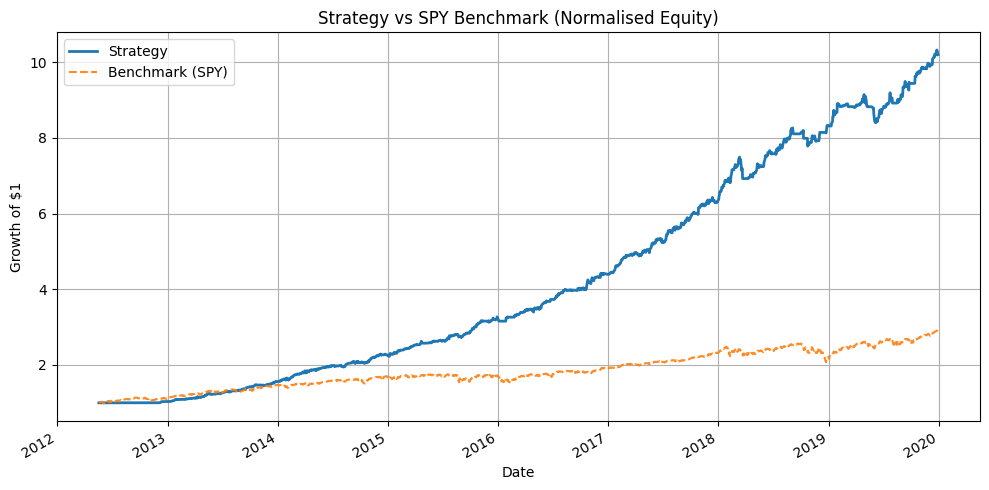

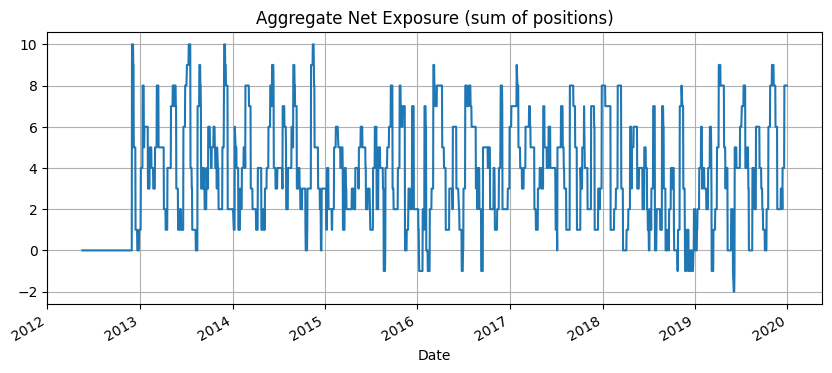

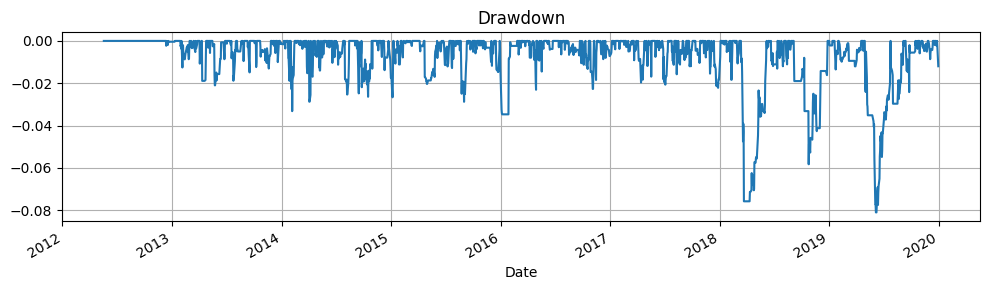


--- Summary ---
Strategy CAGR: 35.74%
Benchmark CAGR: 14.99%
Outperformance: 20.75% per year


In [3]:
start_date = "2010-01-01"
end_date   = "2019-12-31"
stock_list = ["NVDA","MSFT","AAPL","AMZN","META","AVGO","GOOGL","TSLA","GOOG","BRK-B"]

MA_WINDOW = 130
TRAIL_WINDOW = 10
TRAIL_PCT = 0.93
SHORT_THRESHOLD = 0.02
ATR_WIN = 14

COOLDOWN = 3
EPS = 0.005
MIN_HOLD = 5
WEEKLY = True
K_ATR = 2.5
GIVEBACK = 2.0
TIME_STOP = 60

TARGET_VOL = 0.10
GROSS_CAP = 1.0
ROLL_VOL = 20
PERF_LOOKBACK = 63

# --- Run the backtest ---
results = run_backtest(
    start_date=start_date, end_date=end_date, stock_list=stock_list,
    ma_window=MA_WINDOW, trailing_window=TRAIL_WINDOW, trailing_pct=TRAIL_PCT,
    short_threshold=SHORT_THRESHOLD, atr_win=ATR_WIN,
    cooldown_bars=COOLDOWN, reentry_eps=EPS, min_hold=MIN_HOLD, weekly_exec=WEEKLY,
    k_atr_stop=K_ATR, giveback_atr=GIVEBACK, time_stop=TIME_STOP,
    target_vol=TARGET_VOL, gross_cap=GROSS_CAP, roll_vol=ROLL_VOL, perf_lookback=PERF_LOOKBACK,
    initial_capital=500_000.0, compare_spy=True, tag="final"
)

print(results["portfolio_metrics"])

plot_vs_benchmark(results); plot_exposure(results); plot_drawdown(results)

print("\n--- Summary ---")
print(f"Strategy CAGR: {results['portfolio_metrics']['CAGR']*100:.2f}%")
print(f"Benchmark CAGR: {results['benchmark_metrics']['CAGR']*100:.2f}%")
print(f"Outperformance: {(results['portfolio_metrics']['CAGR'] - results['benchmark_metrics']['CAGR'])*100:.2f}% per year")

## Expanding window backtest

In [4]:
from pprint import pprint

years = range(2014, 2019)  # train up to each year, test on next
all_metrics = []

stock_list = ["NVDA","MSFT","AAPL","AMZN","META","AVGO","GOOGL","TSLA","GOOG","BRK-B"]

MA_WINDOW = 130
TRAIL_WINDOW = 10
TRAIL_PCT = 0.93
SHORT_THRESHOLD = 0.02
ATR_WIN = 14

COOLDOWN = 3
EPS = 0.005
MIN_HOLD = 5
WEEKLY = True
K_ATR = 2.5
GIVEBACK = 2.0
TIME_STOP = 60

TARGET_VOL = 0.10
GROSS_CAP = 1.0
ROLL_VOL = 20
PERF_LOOKBACK = 63

for y in years:
    train_start, train_end = "2010-01-01", f"{y}-12-31"
    test_start, test_end = f"{y+1}-01-01", f"{y+1}-12-31"

    print(f"\n[EXPANDING WINDOW] Train: {train_start}→{train_end} | Test: {test_start}→{test_end}")

    # Step 1. Run the strategy (same params) on the test period
    results = run_backtest(
        start_date=test_start, end_date=test_end, stock_list=stock_list,
        ma_window=MA_WINDOW, trailing_window=TRAIL_WINDOW, trailing_pct=TRAIL_PCT,
        short_threshold=SHORT_THRESHOLD, atr_win=ATR_WIN,
        cooldown_bars=COOLDOWN, reentry_eps=EPS, min_hold=MIN_HOLD, weekly_exec=WEEKLY,
        k_atr_stop=K_ATR, giveback_atr=GIVEBACK, time_stop=TIME_STOP,
        target_vol=TARGET_VOL, gross_cap=GROSS_CAP, roll_vol=ROLL_VOL, perf_lookback=PERF_LOOKBACK,
        initial_capital=500_000.0, compare_spy=True, tag=f"expand_{y}"
    )

    # Step 2. Save metrics
    metrics = results["portfolio_metrics"]
    metrics["TrainEnd"] = y
    metrics["TestYear"] = y + 1
    all_metrics.append(metrics)

# Convert to DataFrame for summary
df_metrics = pd.DataFrame(all_metrics)
print("\n=== Expanding-Window Summary ===")
pprint(df_metrics)



[EXPANDING WINDOW] Train: 2010-01-01→2014-12-31 | Test: 2015-01-01→2015-12-31
[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] NVDA: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] MSFT: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] AAPL: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] AMZN: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] META: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] AVGO: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] GOOGL: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] TSLA: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] GOOG: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] BRK-B: 2015-01-02 → 2015-12-30 (251 rows)
[NOTIFY] Saved returns → /Users/tammiekoh/Documents/is4226-final/storage/returns.csv
[NOTIFY] Saved trades  → /Users/tammiekoh/Documents/is4226-final/storage/trades.csv

[EXPANDING WINDOW] Train: 2010-01-01→2015-12-31 | Test: 2016-01-01→2016-12-31
[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOO

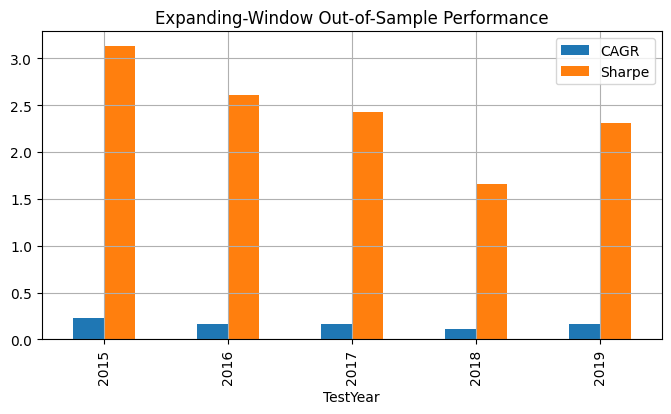

In [5]:
df_metrics.plot(x="TestYear", y=["CAGR", "Sharpe"], kind="bar", figsize=(8,4))
plt.title("Expanding-Window Out-of-Sample Performance")
plt.grid(True)
plt.show()

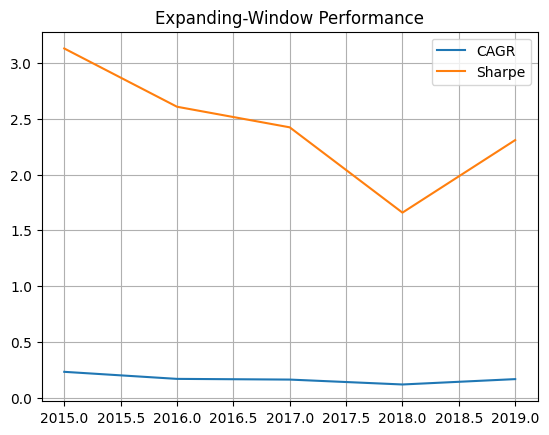

In [7]:
plt.plot(df_metrics["TestYear"], df_metrics["CAGR"], label="CAGR")
plt.plot(df_metrics["TestYear"], df_metrics["Sharpe"], label="Sharpe")
plt.legend(); plt.grid(True); plt.title("Expanding-Window Performance"); plt.show()

# Final Notebook Cell (Graders edit here)
## using in-sample testing

[NOTIFY] Loading 10 symbols: NVDA, MSFT, AAPL, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B
[NOTIFY] NVDA: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] MSFT: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] AAPL: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] AMZN: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] META: 2012-05-18 → 2019-12-30 (1916 rows)
[NOTIFY] AVGO: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] GOOGL: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] TSLA: 2010-06-29 → 2019-12-30 (2393 rows)
[NOTIFY] GOOG: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] BRK-B: 2010-01-04 → 2019-12-30 (2515 rows)
[NOTIFY] Saved returns → /Users/tammiekoh/Documents/is4226-final/storage/returns.csv
[NOTIFY] Saved trades  → /Users/tammiekoh/Documents/is4226-final/storage/trades.csv
{'CAGR': 0.35737308830669634, 'Sharpe': 3.3177283791911214, 'MaxDrawdown': -0.08100995789423171, 'Calmar': 4.411471103012917}


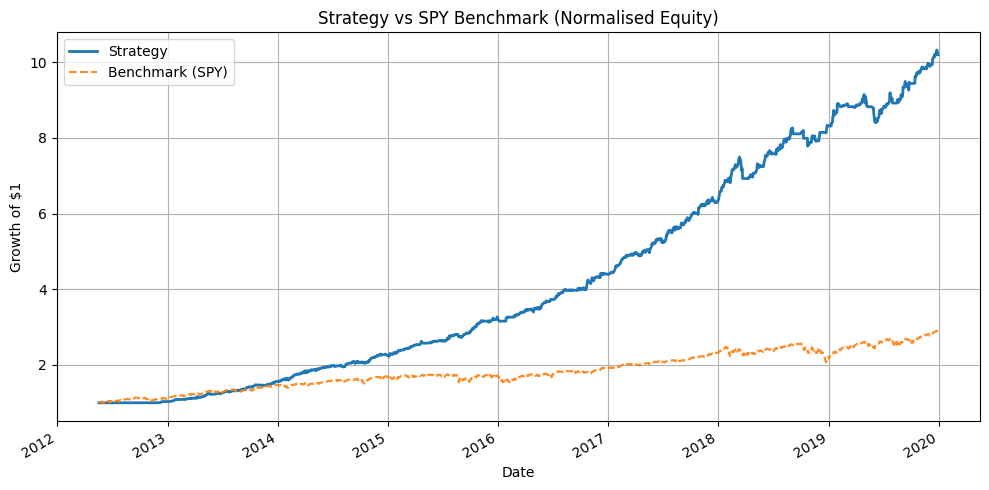

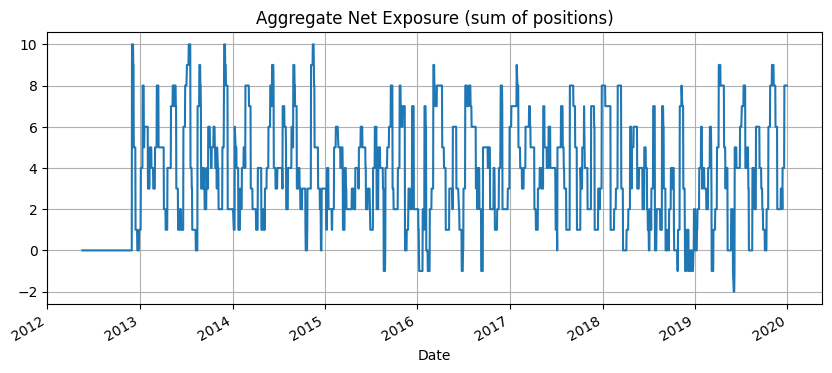

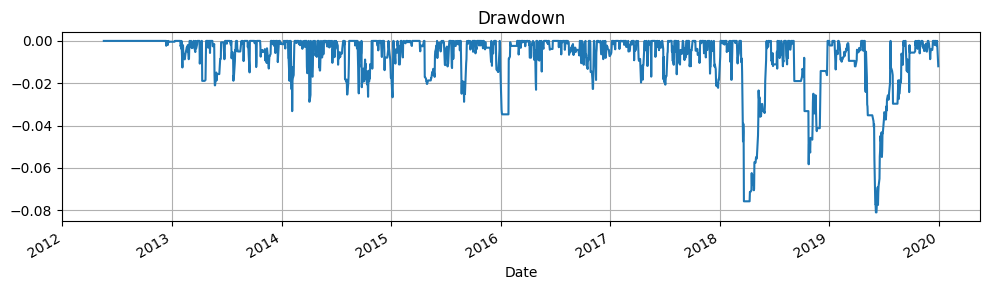


--- Summary ---
Strategy CAGR: 35.74%
Benchmark CAGR: 14.99%
Outperformance: 20.75% per year
Logged to storage/logs/run_backtest.log


In [6]:
start_date = "2010-01-01"
end_date   = "2019-12-31"
stock_list = ["NVDA","MSFT","AAPL","AMZN","META","AVGO","GOOGL","TSLA","GOOG","BRK-B"]

MA_WINDOW = 130
TRAIL_WINDOW = 10
TRAIL_PCT = 0.93
SHORT_THRESHOLD = 0.02
ATR_WIN = 14

COOLDOWN = 3
EPS = 0.005
MIN_HOLD = 5
WEEKLY = True
K_ATR = 2.5
GIVEBACK = 2.0
TIME_STOP = 60

TARGET_VOL = 0.10
GROSS_CAP = 1.0
ROLL_VOL = 20
PERF_LOOKBACK = 63

# --- Run the backtest ---
results = run_backtest(
    start_date=start_date, end_date=end_date, stock_list=stock_list,
    ma_window=MA_WINDOW, trailing_window=TRAIL_WINDOW, trailing_pct=TRAIL_PCT,
    short_threshold=SHORT_THRESHOLD, atr_win=ATR_WIN,
    cooldown_bars=COOLDOWN, reentry_eps=EPS, min_hold=MIN_HOLD, weekly_exec=WEEKLY,
    k_atr_stop=K_ATR, giveback_atr=GIVEBACK, time_stop=TIME_STOP,
    target_vol=TARGET_VOL, gross_cap=GROSS_CAP, roll_vol=ROLL_VOL, perf_lookback=PERF_LOOKBACK,
    initial_capital=500_000.0, compare_spy=True, tag="final"
)

print(results["portfolio_metrics"])

plot_vs_benchmark(results); plot_exposure(results); plot_drawdown(results)

print("\n--- Summary ---")
print(f"Strategy CAGR: {results['portfolio_metrics']['CAGR']*100:.2f}%")
print(f"Benchmark CAGR: {results['benchmark_metrics']['CAGR']*100:.2f}%")
print(f"Outperformance: {(results['portfolio_metrics']['CAGR'] - results['benchmark_metrics']['CAGR'])*100:.2f}% per year")

# minimal logging (saved to /storage/logs/)
log_dir = "./storage/logs"
os.makedirs(log_dir, exist_ok=True)
logging.basicConfig(
    filename=os.path.join(log_dir, "run_backtest.log"),
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logging.info(
    f"Backtest completed | Period: {start_date} → {end_date} | "
    f"Universe: {stock_list} | Metrics: {results['portfolio_metrics']}"
)
print("Logged to storage/logs/run_backtest.log")
